In [67]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, Dopri5, SaveAt, ODETerm

# --- Model definition (must match training) ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key):
        self.mlp = eqx.nn.MLP(in_size=265, out_size=262, width_size=512, depth=4, key=key)

    def __call__(self, P, H, rho, z):
        x = jnp.concatenate([P, H, rho, z])
        return self.mlp(x)

# --- Paths ---
model_dir = "/srv/scratch2/taylor.4264/odd_emu/old_production_models_final"
data_dir = "/srv/scratch2/taylor.4264/odd_emu/old_production_run_final/merged/"
n_chunks = 20  # from 0 to 61

# --- Load normalization constants from full arrays ---
Hz_all = jnp.concatenate([jnp.load(os.path.join(data_dir, f"Hz_{i}.npy")).astype(jnp.float32) for i in range(n_chunks)])
rho_all = jnp.concatenate([jnp.load(os.path.join(data_dir, f"rho_m_{i}.npy")).astype(jnp.float32) for i in range(n_chunks)])

H_mean = jnp.mean(Hz_all)
H_std = jnp.std(Hz_all)

log_rho_flat = jnp.log10(rho_all + 1e-30)
log_rho_mean = jnp.mean(log_rho_flat)
log_rho_std = jnp.std(log_rho_flat)

# --- Initial condition from highest redshift chunk ---
z_idx_start = n_chunks - 1
z_grid = jnp.load(os.path.join(data_dir, f"z_{z_idx_start}.npy"))
pk_all = jnp.load(os.path.join(data_dir, f"pk_nl_{z_idx_start}.npy"))
y0 = jnp.log1p(pk_all[0, 0])  # start at highest z in chunk

# --- Storage for outputs ---
z_all = []
pk_all = []

for i in reversed(range(n_chunks)):
    print(f"Processing chunk {i}...")

    # Load model
    model_file = os.path.join(model_dir, f"learned_model_rhom_zchunk_{i:02d}.eqx")
    model_template = RHS(jax.random.PRNGKey(0))
    model = eqx.tree_deserialise_leaves(model_file, model_template)

    # Load data
    z_grid = jnp.load(os.path.join(data_dir, f"z_{i}.npy"))
    Hz = jnp.load(os.path.join(data_dir, f"Hz_{i}.npy"))[0]
    rho_m = jnp.load(os.path.join(data_dir, f"rho_m_{i}.npy"))[0]

    # Normalize
    Hz = (Hz - H_mean) / H_std
    log_rho_m = (jnp.log10(rho_m + 1e-30) - log_rho_mean) / log_rho_std

    # Reverse for forward-in-time integration
    z_grid = z_grid[::-1]
    Hz = Hz[::-1]
    log_rho_m = log_rho_m[::-1]

    # Skip first entry if not the first chunk (to avoid double-counting)
    if i < z_idx_start:
        z_grid = z_grid[1:]
        Hz = Hz[1:]
        log_rho_m = log_rho_m[1:]

    # Interpolators
    def H_fn(z, z_grid=z_grid, Hz=Hz):
        return jnp.interp(z, z_grid, Hz)

    def rhom_fn(z, z_grid=z_grid, log_rho_m=log_rho_m):
        return jnp.interp(z, z_grid, log_rho_m)

    # RHS function
    def rhs(t, y, args):
        model, H_fn, rhom_fn = args
        H = H_fn(t)
        rho = rhom_fn(t)
        z = jnp.array([t])
        return model(y, jnp.array([H]), jnp.array([rho]), z)

    term = ODETerm(rhs)
    solver = Dopri5()
    saveat = SaveAt(ts=z_grid)

    sol = diffeqsolve(
        term,
        solver,
        t0=float(z_grid[0]),
        t1=float(z_grid[-1]),
        dt0=-1e-2,
        y0=y0,
        args=(model, H_fn, rhom_fn),
        saveat=saveat
    )

    y0 = sol.ys[-1]  # final state becomes initial condition for next chunk
    z_all.append(z_grid)
    pk_all.append(jnp.expm1(sol.ys))

# --- Final output ---
z_all = jnp.concatenate(z_all)
pk_all = jnp.concatenate(pk_all)
print("Integrated P(k,z) shape:", pk_all.shape)

Processing chunk 19...
Processing chunk 18...
Processing chunk 17...
Processing chunk 16...
Processing chunk 15...
Processing chunk 14...
Processing chunk 13...
Processing chunk 12...
Processing chunk 11...
Processing chunk 10...
Processing chunk 9...
Processing chunk 8...
Processing chunk 7...
Processing chunk 6...
Processing chunk 5...
Processing chunk 4...
Processing chunk 3...
Processing chunk 2...
Processing chunk 1...
Processing chunk 0...
Integrated P(k,z) shape: (1981, 262)


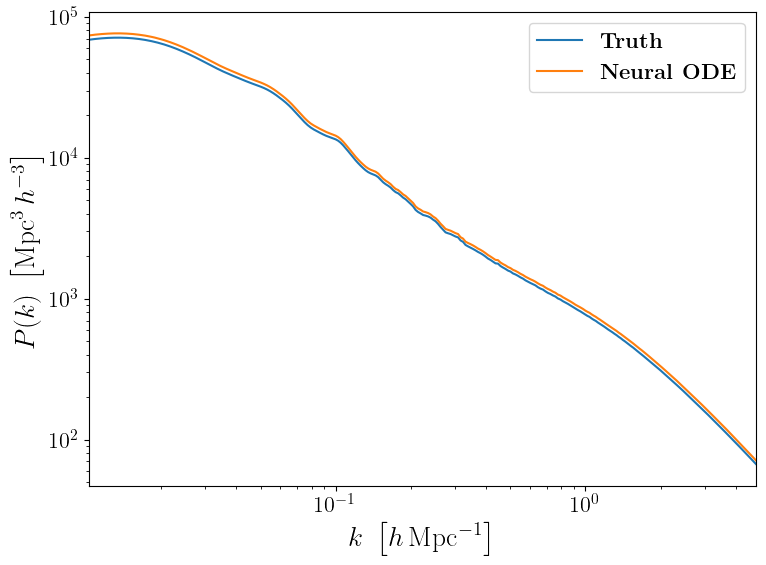

In [ ]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

# --- LaTeX settings ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 18,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# --- Load data ---
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/old_production_run_final/merged"
pk0 = jnp.load(os.path.join(parent_dir, "pk_nl_0.npy"))[0, 0]
k = np.load(os.path.join(parent_dir, "k_0.npy"))

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(k, pk0, label=r"\textbf{Truth}")
plt.plot(k, pk_all[-1], label=r"\textbf{Neural ODE}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(k.min(), k.max())  # Force axis limits to exact k range
plt.xlabel(r"$k\ \left[h\,\mathrm{Mpc}^{-1}\right]$")
plt.ylabel(r"$P(k)\ \left[\mathrm{Mpc}^3\,h^{-3}\right]$")
plt.legend()
plt.tight_layout()
plt.show()

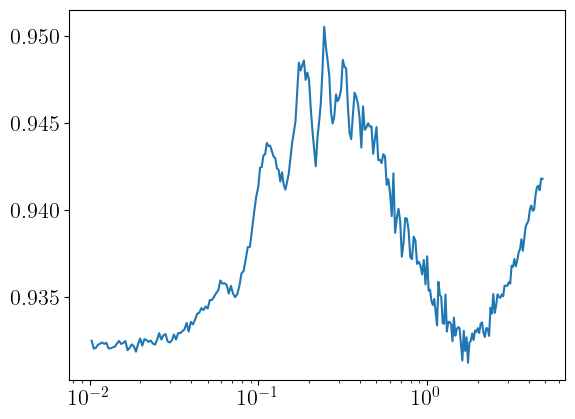

In [71]:
plt.plot(k, pk0 / pk_all[-1])
plt.xscale('log')


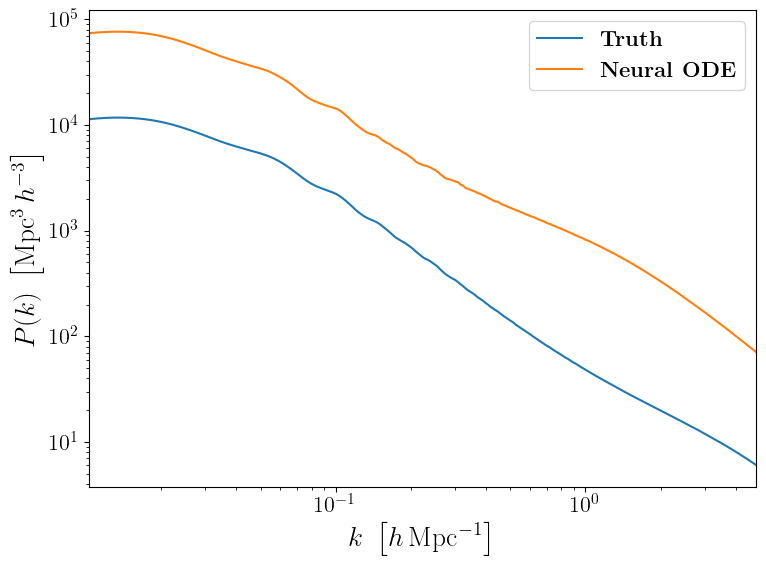

In [85]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

# --- LaTeX settings ---
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 18,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# --- Load data ---
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/old_production_run_final/merged"
pk0 = jnp.load(os.path.join(parent_dir, "pk_nl_30.npy"))[0, 0]
k = np.load(os.path.join(parent_dir, "k_0.npy"))

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(k, pk0, label=r"\textbf{Truth}")
plt.plot(k, pk_all[-1], label=r"\textbf{Neural ODE}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(k.min(), k.max())  # Force axis limits to exact k range
plt.xlabel(r"$k\ \left[h\,\mathrm{Mpc}^{-1}\right]$")
plt.ylabel(r"$P(k)\ \left[\mathrm{Mpc}^3\,h^{-3}\right]$")
plt.legend()
plt.tight_layout()
plt.show()

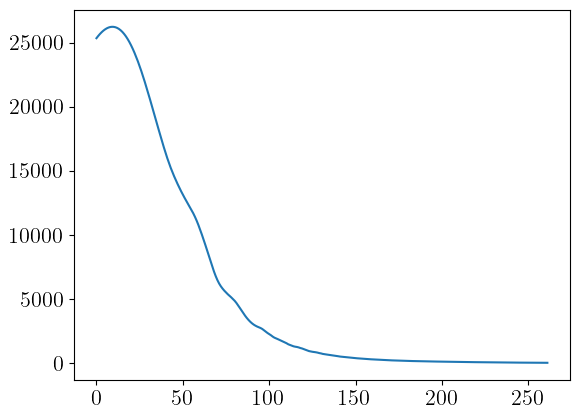

In [80]:
plt.plot(pk_all[0])
plt.show()

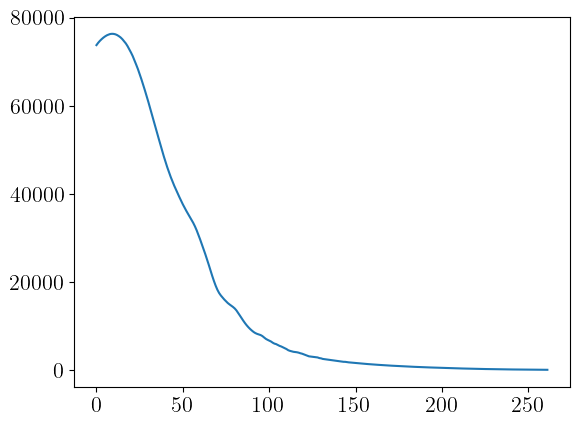

In [84]:
plt.plot(pk_all[-1])
plt.show()